# Refining the Financial Factor Zoo (code)
Author: Matheus Lopes Carrijo.

## 1. Introduction

The central problem we aim to address in this research is the refining of the expansive factor zoo into a subset that offers satisfactory explanation for the cross-section of asset returns through a machine learning approach. The main idea is to reduce dimensionality and achieve a more robust understanding of the most relevant factors driving asset returns. We hypothesize that by employing Principal Component Analysis (PCA) to uncover the structure of the factor space, we can isolate a reduced set of factors that retains most of the explanatory power. Technically, PCA will be employed to distill the extensive array of potential risk factors into a principal linear subspace. A dataset of asset returns (CRPS) and risk factors (Open Source Asset Pricing, OSAP and Global Factor Data, GFD), will be compiled. PCA will be then applied to the asset returns time series, with the principal components aiming to explain a substantial portion of the variance. Specifically, we will retain those components that cumulatively account at least for some reasonable degree of variance in the dataset. This criterion ensures that the principal components represent the key dimensions of systematic risk embedded within the factor zoo. Next, numerous candidate subsets of factors will be generated from our pool of factors given by these two sources of dataset. These subsets will differ in both size and composition, thereby allowing for the exploration of diverse factor combinations. For each subset, the linear subspace spanned by its members will be calculated. The 'distance' between a subset's subspace and the target PCA-derived subspace will be measured using an appropriate metric. This measure quantifies the similarity between the subspaces, enabling us to identify the factor subsets that most closely reproduce the risk structure identified by PCA. 

Finally, Monte Carlo simulation can validate the robustness of this selected factor subset and provide a better understanding related to performance under varying market conditions, for example. Simulated asset returns will be generated based on exposure to both the subset factors and the principal components. Across numerous simulations, the explanatory power of the subset-based models relative to a benchmark PCA model will be compared. Key metrics for evaluation could be R-squared, which measures the proportion of the variance in the dependent variable that is predictable from the independent variables, and adjusted R-squared, which adjusts for the number of predictors in the model, thereby providing a metric that penalizes model complexity. Additional metrics such as pricing errors and out-of-sample predictive accuracy could also be analyzed to assess the practical applicability of the models. By evaluating these metrics, we aim to identify the subsets that not only replicate the explanatory power of a more complex PCA model but also maintain consistent performance across different simulated scenarios. This robust assessment will help in confirming the reliability and effectiveness of the simpler factor models in capturing asset return dynamics.

Below is the libraries we will need. 

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlite3
from datetime import datetime
import seaborn as sns
import os

# Ignore DtypeWarning and FutureWarning and DeprecationWarning
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

We will use SQLite-database to organize our database, which is the C-language
library that implements a SQL database engine. This code snippet below will
work only If you are returning to this code and already have stored the
required datasets in the `RFFZ.sqlite` file stored in the `data` folder, i.e.
you are retrieving the data you have stored once. Then, you can skip the part 
of the code which is managing the database. If you rather are running this code
for the first time, you need to skip this snippet code below and follow all the
code part that manages the dataset.

Let's first inspect if our RFFZ SQL-database have the tables we want:

In [3]:
# Connect to the SQLite database
RFFZ = sqlite3.connect('data/RFFZ.sqlite')

# Create a cursor object to interact with the database
cursor = RFFZ.cursor()

# Query to list all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all table names
tables = cursor.fetchall()

# Print out all the tables
print("Tables in the database:")
for table_name in tables:
    print(table_name[0])

Tables in the database:
crsp_m
cpi_m
rf_m


We can also check the structure of these tables:

In [4]:
# Optionally, inspect the structure of each table
for table_name in tables:
    print(f"\nStructure of table '{table_name[0]}':")
    cursor.execute(f"PRAGMA table_info({table_name[0]});")
    columns = cursor.fetchall()
    for column in columns:
        print(column)

# Close the cursor and connection
cursor.close()
RFFZ.close()


Structure of table 'crsp_m':
(0, 'permno', 'INTEGER', 0, None, 0)
(1, 'month', 'TIMESTAMP', 0, None, 0)
(2, 'shrcd', 'REAL', 0, None, 0)
(3, 'exchcd', 'REAL', 0, None, 0)
(4, 'siccd', 'REAL', 0, None, 0)
(5, 'comnam', 'TEXT', 0, None, 0)
(6, 'dlstcd', 'REAL', 0, None, 0)
(7, 'dlret', 'REAL', 0, None, 0)
(8, 'prc', 'REAL', 0, None, 0)
(9, 'ret', 'REAL', 0, None, 0)
(10, 'shrout', 'REAL', 0, None, 0)
(11, 'ret_excess', 'REAL', 0, None, 0)
(12, 'mktcap', 'REAL', 0, None, 0)
(13, 'exchange', 'TEXT', 0, None, 0)
(14, 'industry', 'TEXT', 0, None, 0)

Structure of table 'cpi_m':
(0, 'month', 'TIMESTAMP', 0, None, 0)
(1, 'cpi', 'REAL', 0, None, 0)

Structure of table 'rf_m':
(0, 'month', 'TIMESTAMP', 0, None, 0)
(1, 'rf', 'REAL', 0, None, 0)


Have inspected the datasets stocked in the `data/RFFZ.sqlite` path, we now read
these tables:

In [3]:
RFFZ = sqlite3.connect(database="data/RFFZ.sqlite")

crsp_m = pd.read_sql_query(sql="SELECT * FROM crsp_m", con=RFFZ, 
                            parse_dates={"month"})

cpi_m = pd.read_sql_query(sql="SELECT * FROM cpi_m", con=RFFZ, 
                          parse_dates={"month"})

rf_m  = pd.read_sql_query(sql="SELECT month, rf FROM rf_m ", con=RFFZ, 
                          parse_dates={"month"})

# Close the connection
RFFZ.close()

## 2. Datasets

### 2.1 Center for Research in Security Prices (CRSP) 

The Center for Research in Security Prices (CRSP) dataset is one of the most 
comprehensive and widely used databases in finance research. Maintained and 
provided by the University of Chicago Booth School of Business, CRSP is a 
cornerstone resource for both academic and professional studies in finance. The
dataset offers a vast collection of historical data on securities traded on 
major U.S. exchanges, including the New York Stock Exchange (NYSE), NASDAQ, and
others. It includes detailed information on stock prices, returns, dividends, 
trading volumes, and various corporate actions, making it an invaluable tool 
for analyzing financial markets, asset pricing, and corporate finance.

CRSP data is typically accessed through academic institutions, financial
research platforms such as Wharton Research Data Services (WRDS), and other 
specialized data vendors. Access often requires a subscription or institutional
affiliation due to its proprietary nature. Researchers and students at 
subscribing universities can access the data for academic purposes, while 
financial professionals use it for market analysis, back-testing trading 
strategies, and more.

One of the key features of the CRSP dataset is its structure, which is designed 
to facilitate longitudinal studies. This allows researchers to track the 
performance of individual securities over time, with unique identifiers like 
PERMNO and PERMCO that remain constant even when a company's name or ticker 
symbol changes. These identifiers ensure consistency in historical analysis, 
making CRSP particularly valuable for conducting event studies, portfolio 
analyses, and other types of financial research.

Given its comprehensive nature and the depth of historical data it covers, the 
CRSP dataset is frequently cited in academic papers and research reports. It is
especially crucial for empirical research in asset pricing, where historical 
returns and other market variables are analyzed to test financial theories and 
models. The robustness and reliability of the CRSP data make it a fundamental 
tool in both teaching and research across finance and economics disciplines.


After accessing and downloading the CRSP database, ensure that the file is 
saved in the same directory as your code. We will refer to this file as 
`CRSP-Stock-Monthly.csv`.

Let's begin by examining the columns of our main dataset:

In [2]:
print(pd.read_csv("CRSP-Stock-Monthly.csv", nrows=0).columns)

Index(['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP',
       'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT',
       'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT',
       'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG',
       'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM',
       'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD',
       'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'ALTPRC', 'SPREAD',
       'ALTPRCDT', 'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')


The following table provides a quick reference to the variables in our CRSP 
dataset. For more details, users should refer to the 
official CRSP documentation available at 
https://wrds-www.wharton.upenn.edu/documents/399/Data_Descriptions_Guide.pdf

**Column Descriptions**

| **Column Name** | **Description** |
|-----------------|-----------------|
| `PERMNO`        | Permanent number assigned to each security by CRSP, uniquely identifying the security. |
| `date`          | Calendar date of the observation, representing the specific time period of the data. |
| `NAMEENDT`      | End date when the company name or other identifying information was last valid. |
| `SHRCD`         | Share class code, indicating the type of shares (e.g., common stock, preferred stock). |
| `EXCHCD`        | Exchange code, indicating the primary exchange where the security is traded. |
| `SICCD`         | Standard Industrial Classification Code, representing the industry of the company. |
| `NCUSIP`        | Updated CUSIP number after adjustments for corporate actions. |
| `TICKER`        | Trading symbol of the stock, commonly used for identifying the security on exchanges. |
| `COMNAM`        | Name of the company issuing the security. |
| `SHRCLS`        | Share class identifier, indicating different classes of shares within the same company. |
| `TSYMBOL`       | Alternative trading symbol for the security, similar to TICKER. |
| `NAICS`         | North American Industry Classification System code, indicating the industry classification. |
| `PRIMEXCH`      | Primary exchange code, where the security is predominantly traded. |
| `TRDSTAT`       | Trading status of the security, indicating whether it is actively traded, suspended, or delisted. |
| `SECSTAT`       | Security status, providing details on whether the security is active, inactive, or delisted. |
| `PERMCO`        | Permanent company identifier, grouping all securities issued by the same company. |
| `ISSUNO`        | Issue number assigned to the security, differentiating between different issues from the same company. |
| `HEXCD`         | Historical exchange code, representing the exchange where the security was previously listed. |
| `HSICCD`        | Historical SIC code, indicating the company's industry classification in earlier periods. |
| `CUSIP`         | Unique identifier for each security, provided by the Committee on Uniform Securities Identification Procedures. |
| `DCLRDT`        | Declaration date of a dividend, indicating when the dividend was announced. |
| `DLAMT`         | Amount After Delisting. It is the value of a security after it delists from an exchange.  |
| `DLPDT`         | Delisting payment date, indicating when a delisting payment was made to shareholders. |
| `DLSTCD`        | Code indicating the reason for the security's delisting. |
| `NEXTDT`        | Next date when a corporate event (like a dividend payment) is expected. |
| `PAYDT`         | Payment date for dividends or other distributions to shareholders. |
| `RCRDDT`        | Record date for dividends or other distributions, indicating the date by which shareholders must own the stock to receive the dividend. |
| `SHRFLG`        | Share flag, indicating specific conditions or restrictions on the shares. |
| `HSICMG`        | Historical SIC Major Group code, providing a broader industry classification within the SIC system. |
| `HSICIG`        | Historical SIC Industry Group code, offering a more specific classification within the broader SIC Major Group. |
| `DISTCD`        | Distribution code, related to dividends or capital gains distributions. |
| `DIVAMT`        | Dividend amount distributed per share to shareholders. |
| `FACPR`         | Adjustment factor for price, used to account for stock splits or other corporate actions. |
| `FACSHR`        | Adjustment factor for shares outstanding, used to adjust the share count after stock splits or similar events. |
| `ACPERM`        | Indicator showing whether the security has an active or inactive PERMNO. |
| `ACCOMP`        | Acquiring company identifier, indicating the company that acquired or merged with the original issuer. |
| `SHRENDDT`      | Date when the shares ended, were delisted, or otherwise ceased to trade. |
| `NWPERM`        | New PERMNO assigned after corporate restructuring, such as mergers or spin-offs. |
| `DLRETX`        | Delisting return excluding dividends, reflecting the return for the security before it was delisted. |
| `DLPRC`         | Delisting price, the final price of the security before it was removed from trading. |
| `DLRET`         | Delisting return, capturing the return on the final trading day before delisting. |
| `TRTSCD`        | Code related to the transaction status, providing details about the nature of transactions. |
| `NMSIND`        | NASDAQ National Market System indicator, signaling whether the security is part of the NASDAQ National Market System. |
| `MMCNT`         | Market maker count, indicating the number of market makers trading the security. |
| `NSDINX`        | NASDAQ index code, possibly related to the inclusion of the security in specific NASDAQ indices. |
| `BIDLO`         | Lowest bid price during the period. |
| `ASKHI`         | Highest ask price during the period. |
| `PRC`           | Closing price or bid/ask average of the stock. |
| `VOL`           | Trading volume of the security, indicating how many shares were traded. |
| `RET`           | Total return, including dividends, showing the percentage change in the security's price over the period. |
| `BID`           | Bid price of the stock, representing the highest price a buyer is willing to pay. |
| `ASK`           | Ask price of the stock, representing the lowest price a seller is willing to accept. |
| `SHROUT`        | Number of shares outstanding, indicating the total shares currently issued by the company. |
| `CFACPR`        | Cumulative factor to adjust price for stock splits or other corporate actions. |
| `CFACSHR`       | Cumulative factor to adjust shares outstanding after events like stock splits. |
| `ALTPRC`        | Alternative price, which could be an adjusted or calculated price different from the regular closing price. |
| `SPREAD`        | Bid-ask spread, showing the difference between the highest bid and lowest ask prices. |
| `ALTPRCDT`      | Date associated with the alternative price (`ALTPRC`), indicating when this price was recorded. |
| `RETX`          | Return excluding dividends, showing the percentage change in the security's price without accounting for dividends. |
| `vwretd`        | Value-weighted return including dividends for the market index. |
| `vwretx`        | Value-weighted return excluding dividends for the market index. |
| `ewretd`        | Equal-weighted return including dividends for the market index. |
| `ewretx`        | Equal-weighted return excluding dividends for the market index. |
| `sprtrn`        | S&P 500 index return, showing the percentage change in the S&P 500 index over the period. |

Now, we need to set the period we'd want to consider in our analysis 

In [9]:
start_date_1926 = pd.to_datetime("1926-01-31") # Entire sample
#start_date_1962 = "1962-07-31" # AMEX birth. Not used.
# Convert the start date to a datetime object
start_date_1973 = pd.to_datetime("1973-01-31") # NASDAQ birth is 1972-12-31
end_date = pd.to_datetime("2023-12-31") 

Next, we retrieve and processes financial data related to the Consumer Price
Index (CPI) and the risk free rate available in the Fama-French three-factor 
model data. The CPI data is fetched from the Federal Reserve Economic Data 
(FRED) using `pandas_datareader`, then normalized relative to the latest value
for comparison across different periods. The Fama-French data is obtained from
the Fama-French database, scaled to decimal form.

In [10]:
# Data about CPI from FRED
cpi_m = (pdr.DataReader(name="CPIAUCNS", data_source="fred", 
                        start="1972-12-31", end=end_date)
            .reset_index(names="month")
            .rename(columns={"CPIAUCNS": "cpi"})
            .assign(cpi=lambda x: x["cpi"]/x["cpi"].iloc[-1]))

cpi_m['month'] = (cpi_m['month'].dt.to_period('M').dt.to_timestamp('M'))

# Data about risk free (rf) from fama french database
rf_m  = (pdr.DataReader(
  name="F-F_Research_Data_Factors",
  data_source="famafrench", 
  start="1972-12-31", 
  end=end_date)[0][['RF']].divide(100)
                          .reset_index(names="month")
                          .assign(month=lambda x: 
                                  pd.to_datetime(x["month"].astype(str)))
                          .rename(str.lower, axis="columns"))

rf_m['month'] = (rf_m['month'].dt.to_period('M').dt.to_timestamp('M'))

We can look at the head of these datasets:

In [11]:
cpi_m.head()

,month,cpi
0,1973-01-31,0.138877
1,1973-02-28,0.139855
2,1973-03-31,0.141159
3,1973-04-30,0.142137
4,1973-05-31,0.143115


In [12]:
rf_m.head()

,month,rf
0,1972-12-31,0.0037
1,1973-01-31,0.0044
2,1973-02-28,0.0041
3,1973-03-31,0.0046
4,1973-04-30,0.0052


Now we process CRSP stock data to prepare it for subsequent analysis. The
procedure begins by defining the file path for the  dataset and specifying a
list of relevant columns to retain. These columns include crucial information
such as the security identifier (`PERMNO`), returns (`RET`), delisting returns
(`DLRET`), delisting code (`DLSTCD`), shares outstanding (`SHROUT`), price 
(`PRC`), exchange code (`EXCHCD`), company name (`COMNAM`), and the Standard 
Industrial Classification (`SICCD`) code. 

To handle the large size of the dataset, the CSV file is read in chunks, where 
each chunk includes only the specified columns. This chunk-wise processing 
allows the code to work efficiently without overwhelming memory resources. 
Within each chunk, the data undergoes several transformations and filtering 
steps. First, the relevant columns, such as `RET`, `DLRET`, and `SICCD`, are 
converted to numeric format, with any non-numeric values being coerced to `NaN`. 
This conversion ensures that subsequent calculations and transformations can be 
applied uniformly across the dataset. Additionally, the `SHROUT` column, which 
represents shares outstanding in thousands, is scaled up by multiplying by 
1,000 to reflect the actual number of shares outstanding. The `date` column is 
also converted to a standardized datetime format and renamed as `month`, with 
all dates adjusted to correspond to the end of the month. This adjustment 
ensures consistency in the temporal structure of the dataset.

The code implements a critical filtering process to focus on relevant 
securities. Specifically, it selects only common stocks, defined by share codes 
`10` and `11`, and further restricts the dataset to stocks listed on the NYSE, 
NASDAQ, and AMEX exchanges, as indicated by the `EXCHCD` values. This filtering 
is crucial for isolating the target sample of securities, which are most 
commonly analyzed in empirical finance research.

One of the significant enhancements in this code is its handling of delisting 
returns. In instances where a stock has a valid delisting code but a missing 
delisting return, the code applies specific adjustments based on the exchange 
and delisting code. For stocks delisted on the NYSE, NASDAQ, or AMEX with 
delisting codes between `500` and `584`, a delisting return of `-0.30` is 
assigned if the delisting return is missing. For stocks on NASDAQ with the same 
delisting codes, the assigned delisting return is `-0.55` in the absence of a 
reported value. To avoid extreme delisting returns, any delisting return values 
lower than `-1` are capped at `-1`. Furthermore, if no delisting return is 
available, the code assigns a value of `0`. 

The code also integrates the regular returns (`RET`) and delisting returns 
(`DLRET`) into a single adjusted return figure. Using the formula `(1 + RET) * 
(1 + DLRET) - 1`, it calculates the total return for a given stock during a 
month in which it might have been delisted. This adjustment ensures that both 
the standard return and the delisting return are accounted for in the overall 
return calculation. Additionally, if the regular return is missing but a 
delisting return is present, the code sets the return equal to the delisting 
return. This ensures that missing regular returns do not distort the overall 
return calculations.


In [23]:
# Define the file path
file_path = "CRSP-Stock-Monthly.csv"

# List of columns to keep (add 'DLRET' and 'DLSTCD' for delisting return 
# and delisting code)
columns_to_keep = [
    'date', 'PERMNO', 'SHRCD', 'RET', 'DLRET', 'DLSTCD', 'SHROUT', 'PRC',
    'EXCHCD', 'COMNAM', 'SICCD'
]

# Initialize an empty list to store results
data_list = []

# Define the chunk size
chunk_size = 100000

# Iterate through the file in chunks and read only the necessary columns
for chunk in pd.read_csv(file_path, usecols=columns_to_keep, 
                         chunksize=chunk_size):
    
    # Convert columns to numeric, forcing non-numeric values to NaN
    chunk['RET'] = pd.to_numeric(chunk['RET'], errors='coerce')
    chunk['DLRET'] = pd.to_numeric(chunk['DLRET'], errors='coerce')
    chunk['SICCD'] = pd.to_numeric(chunk['SICCD'], errors='coerce')
    
    # CRSP originally provides the share outstanding in thousand. We "fix" 
    # that.
    chunk['SHROUT'] = chunk['SHROUT'] * 1000
    
    # Convert date column to datetime format
    chunk['date'] = pd.to_datetime(chunk['date'], format='%Y-%m-%d')

    # Rename columns to lowercase and replace 'date' by 'month'
    chunk.columns = [col.lower() for col in chunk.columns]
    chunk = chunk.rename(columns={'date': 'month'})

    # Adjust all dates to the end of the month
    chunk['month'] = chunk['month'].dt.to_period('M').dt.to_timestamp('M')

    # Filter the data to load only records starting from 'start_date_1973'
    chunk = chunk[chunk['month'] >= start_date_1973]

    # Apply filters for specific exchanges (NYSE, NASDAQ, AMEX)
    chunk_filtered = chunk[chunk["exchcd"].isin([1, 31, 2, 32, 3, 33])]
    
    # Apply filters for ordinary common stocks (share codes 10 and 11)
    chunk_filtered = chunk_filtered[chunk_filtered["shrcd"].isin([10, 11])]

    # Exclude financial firms (SIC codes between 6000 and 6999)
    chunk_filtered = chunk_filtered[~chunk_filtered['siccd'].between(6000, 6999)]
    
    # Adjust dlret for specific delisting codes and exchanges
    chunk_filtered['dlret'] = chunk_filtered.apply(
        lambda row: -0.30 if (
            pd.isna(row['dlret']) and row['dlstcd'] in range(500, 585) and 
            row['exchcd'] in [1, 31, 2, 32]
        ) else (
            -0.55 if (
                pd.isna(row['dlret']) and row['dlstcd'] in range(500, 585) and
                row['exchcd'] in [3, 33]
            ) else row['dlret']
        ),
        axis=1
    )

    # Cap dlret to a minimum of -1
    chunk_filtered['dlret'] = chunk_filtered['dlret'].apply(
        lambda x: max(x, -1) if not pd.isna(x) else x
    )

    # Fill missing delisting returns with 0
    chunk_filtered['dlret'] = chunk_filtered['dlret'].fillna(0)

    # Adjust the returns using the formula: (1 + ret) * (1 + dlret) - 1
    chunk_filtered['ret'] = (
        (1 + chunk_filtered['ret']) * (1 + chunk_filtered['dlret']) - 1
    )

    # If ret is missing but dlret is not, set ret = dlret
    chunk_filtered['ret'] = chunk_filtered.apply(
        lambda row: row['dlret'] if pd.isna(row['ret']) and row['dlret'] != 0 
        else row['ret'], axis=1
    )
    
    # Append the filtered chunk to the list
    data_list.append(chunk_filtered)
    
# Concatenate all filtered chunks into a single DataFrame
crsp_m = pd.concat(data_list, axis=0).reset_index(drop=True)

# Filter out firms that have less than 60 observations
obs_per_permno = crsp_m.groupby('permno').size().reset_index(name='n_obs')
valid_permnos = obs_per_permno[obs_per_permno['n_obs'] >= 60]['permno']
crsp_m = crsp_m[crsp_m['permno'].isin(valid_permnos)]

# Select only stocks where the minimum price ('prc') across all observations 
# is greater than $5
permnos_with_high_price = crsp_m.groupby('permno')['prc'].min()
selected_permnos = permnos_with_high_price[permnos_with_high_price > 5].index
# Filter the original dataset to include only these selected stocks
crsp_m = crsp_m[crsp_m['permno'].isin(selected_permnos)]

# Integrate the risk-free rate from Fama-French three-factor model data 
# into the CRSP monthly data to calculate excess returns. The excess return is
# the return earned by a security or portfolio over the risk-free rate.
crsp_m = (crsp_m
  .merge(rf_m[["month", "rf"]], how="left", on="month")
  .assign(ret_excess=lambda x: x["ret"]-x["rf"])
  .assign(ret_excess=lambda x: x["ret_excess"].clip(lower=-1))
  .drop(columns=["rf"])
)


In [26]:
# Group by 'permno' and count the missing values in 'RET'
missing_returns_count = crsp_m.groupby('permno')['ret'].apply(lambda x: x.isna().sum())

# Calculate the percentage of missing values for each stock
total_observations_per_stock = crsp_m.groupby('permno')['ret'].size()
missing_returns_percentage = (missing_returns_count / total_observations_per_stock) * 100

# Create a DataFrame to summarize the missing values count and percentage
missing_data_summary = pd.DataFrame({
    'Missing Count': missing_returns_count,
    'Total Observations': total_observations_per_stock,
    'Missing Percentage': missing_returns_percentage
})

# Sort by the number or percentage of missing values
missing_data_summary_sorted = missing_data_summary.sort_values(by='Missing Percentage', ascending=False)

# Show stocks with the highest percentage of missing values
print(missing_data_summary_sorted.head(800))  


        Missing Count  Total Observations  Missing Percentage
permno                                                       
14867              15                 103           14.563107
54383               7                  83            8.433735
48362               5                  69            7.246377
90438               4                  70            5.714286
14792               3                  61            4.918033
...               ...                 ...                 ...
92618               1                 124            0.806452
71765               1                 124            0.806452
14141               1                 124            0.806452
14169               1                 124            0.806452
11345               1                 125            0.800000

[800 rows x 3 columns]


In [50]:
# Get the start date (earliest observation) for each stock (permno)
start_dates = crsp_m.groupby('permno')['month'].min().reset_index()

# Rename columns for clarity
start_dates.columns = ['permno', 'start_date']

# Sort the DataFrame by the start date (oldest to newest)
start_dates_sorted = start_dates.sort_values(by='start_date', ascending=True)

# Display the sorted start dates for each stock
print(start_dates_sorted)


     permno start_date
0     10006 1973-01-31
720   23579 1973-01-31
721   23624 1973-01-31
722   23640 1973-01-31
723   23712 1973-01-31
..      ...        ...
602   18311 2018-12-31
603   18312 2018-12-31
605   18368 2019-01-31
606   18369 2019-01-31
457   16437 2019-09-30

[1965 rows x 2 columns]


Let's look at the head of this dataframe before we implement some changes:

In [9]:
crsp_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3149749 entries, 0 to 3149748
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   permno      int64         
 1   month       datetime64[ns]
 2   shrcd       float64       
 3   exchcd      float64       
 4   siccd       float64       
 5   comnam      object        
 6   dlstcd      float64       
 7   dlret       float64       
 8   prc         float64       
 9   ret         float64       
 10  shrout      float64       
 11  ret_excess  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 288.4+ MB


In [10]:
crsp_m.head()

,permno,month,shrcd,exchcd,siccd,comnam,dlstcd,dlret,prc,ret,shrout,ret_excess
0,10000,1986-01-31,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-4.37500,NaN,3680000.0,NaN
1,10000,1986-02-28,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-3.25000,-0.257143,3680000.0,-0.262443
2,10000,1986-03-31,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-4.43750,0.365385,3680000.0,0.359385
3,10000,1986-04-30,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-4.00000,-0.098592,3793000.0,-0.103792
4,10000,1986-05-31,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-3.10938,-0.222656,3793000.0,-0.227556


Following the approach suggested by Bali, Engle, and Murray (2016),
the absolute value of the market cap is calculated. This is necessary because,
in cases where there is no trading activity, the CRSP dataset may report the
price as the negative of the average of the most recent bid and ask prices. By
taking the absolute value, the code ensures that the market cap reflects the
correct magnitude of the stock's value, regardless of whether the price was
reported as negative.

The market cap is calculated by multiplying the number of shares outstanding
(`shrout`) by the alternative price (`prc`), with the absolute value applied
to handle any negative prices. The resulting market cap values are then rounded
to two decimal places..

In [30]:
crsp_m = (crsp_m
  .assign(mktcap=lambda x: abs(x["shrout"]*x["prc"]))) 
  
crsp_m['mktcap'] = crsp_m['mktcap'].round(2)

Below we transform the primary listing exchange codes in the CRSP dataset
into explicit exchange names. According to the "Data Descriptions Guide CRSP 
US Stock & US Index Databases" by CRSP, the `exchcd` field contains numeric
codes that correspond to specific stock exchanges. The codes range from those
indicating halted or suspended trading, to codes representing major exchanges
like NYSE, AMEX, and NASDAQ, as well as various other exchanges.

The exchange codes are as follows:

- -2: Halted by Primary Listing Exchange
- -1: Suspended by Primary Listing Exchange
-  0: Not Trading on Primary Listing Exchange
-  1 or 31: NYSE
-  2 or 32: NYSE American (formerly AMEX and NYSE MKT)
-  3 or 33: NASDAQ
-  4: Arca
-  5: BZX Exchange
-  6: Investors Exchange (IEX)
- 10: Boston Stock Exchange
- 13: Chicago Stock Exchange
- 16: Pacific Stock Exchange
- 17: Philadelphia Stock Exchange
- 20: Over-The-Counter (Non-NASDAQ Dealer Quotations)

The goal is to categorize the primary exchanges (NYSE, AMEX, and NASDAQ) using
these codes, while classifying all other exchanges under the label "Other". 

The function `assign_exchange` is defined to map the `exchcd` values to their
respective exchange names:


In [31]:
def assign_exchange(exchcd):

    if (exchcd == 1) or (exchcd == 31):
        return "NYSE"
    elif (exchcd == 2) or (exchcd == 32):
        return "AMEX"
    elif (exchcd == 3) or (exchcd == 33):
        return "NASDAQ"
    else: 
        return "Other"

crsp_m["exchange"] = crsp_m["exchcd"].apply(assign_exchange)

Now we transform the Standard Industrial Classification (SIC) codes into
industry descriptions based on the US Securities and Exchange Comission
(see https://www.sec.gov/search-filings/standard-industrial-classification-sic-code-list). 
The SIC codes are numeric codes used to classify industries in which companies
operate. The function `assign_industry` is  defined to map SIC codes (`siccd`) 
to their corresponding industry descriptions. The function checks the range of 
the SIC code and returns the appropriate industry name:

In [32]:
def assign_industry(siccd):
    
    if 100 <= siccd <= 999:
        return "Agriculture"
    elif 1000 <= siccd <= 1499:
        return "Mining"
    elif 1500 <= siccd <= 1799:
        return "Construction"
    elif 2000 <= siccd <= 3999:
        return "Manufacturing"
    elif 4000 <= siccd <= 4999:
        return "Utilities"
    elif 5000 <= siccd <= 5199:
        return "Wholesale"
    elif 5200 <= siccd <= 5999:
        return "Retail"
    elif 6000 <= siccd <= 6799:
        return "Finance"
    elif 7000 <= siccd <= 8999:
        return "Services"
    elif 9100 <= siccd <= 9729:
        return "Public"
    elif 9900 <= siccd <= 9999:
        return "Nonclassifiable"
    else:
        return "Missing"

crsp_m["industry"] = crsp_m["siccd"].apply(assign_industry)

Now let's look again at our CRSP dataset with these just implemented changes:

In [14]:
crsp_m.head()

,permno,month,shrcd,exchcd,siccd,comnam,dlstcd,dlret,prc,ret,shrout,ret_excess,mktcap,exchange,industry
0,10000,1986-01-31,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-4.37500,NaN,3680000.0,NaN,16100000.00,NASDAQ,Manufacturing
1,10000,1986-02-28,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-3.25000,-0.257143,3680000.0,-0.262443,11960000.00,NASDAQ,Manufacturing
2,10000,1986-03-31,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-4.43750,0.365385,3680000.0,0.359385,16330000.00,NASDAQ,Manufacturing
3,10000,1986-04-30,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-4.00000,-0.098592,3793000.0,-0.103792,15172000.00,NASDAQ,Manufacturing
4,10000,1986-05-31,10.0,3.0,3990.0,OPTIMUM MANUFACTURING INC,NaN,0.0,-3.10938,-0.222656,3793000.0,-0.227556,11793878.34,NASDAQ,Manufacturing


With the managed `crsp_m` database, we now want to visualize the data,
specially the number and market cap of securities by both exchange and industry.
Below we describe the steps to generate the plots. 

We start plotting the number and market cap of securities by exchange. 

Firt, we group the data by exchange and date, then count the number of securities:

In [34]:
securities_per_exchange = (crsp_m.groupby(["exchange", "month"])
                                 .size().reset_index(name="n"))

So calculate the total number of stocks per month:

In [35]:
total_stocks_per_month = (crsp_m.groupby("month").size()
                                .reset_index(name="total_n"))

Plotting the data with seaborn and matplotlib:

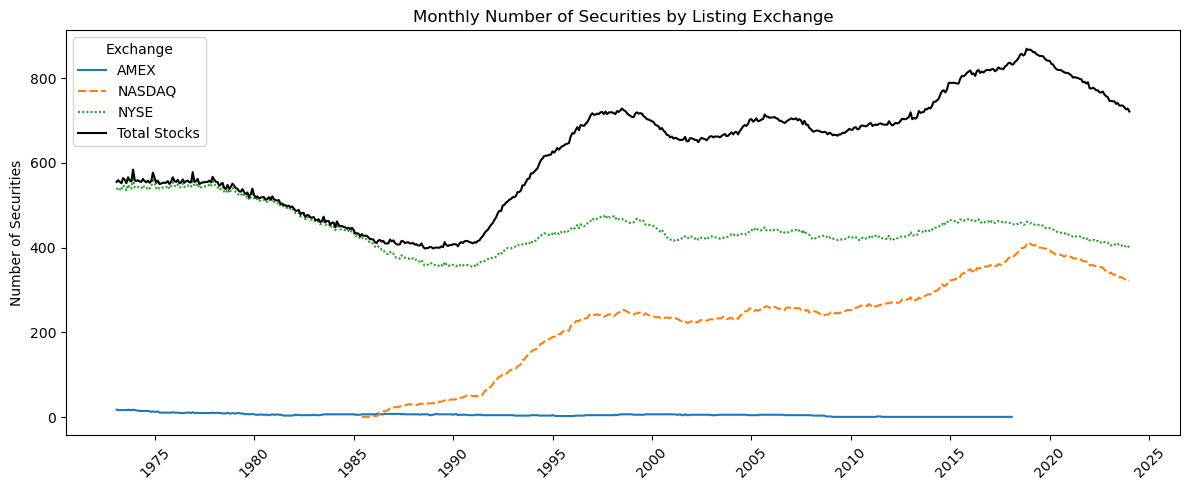

In [36]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=securities_per_exchange[
    securities_per_exchange['month'].between('1926-07-31', '2023-12-31')], 
             x="month", y="n", hue="exchange", style="exchange", legend='full')

# Plot the total number of stocks
sns.lineplot(data=total_stocks_per_month[
    total_stocks_per_month['month'].between('1926-07-31', 
                                            '2023-12-31')], 
             x="month", y="total_n", color="black", label="Total Stocks")

# Formatting the plot
plt.xlabel("")
plt.ylabel("Number of Securities")
plt.title("Monthly Number of Securities by Listing Exchange")

# Set major ticks format to every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.legend(title="Exchange")
plt.tight_layout()

# Show the plot
plt.show()

From this plot we can see that the NYSE stock market is the oldest one, 
starting in the 20s. In the 60s there was the birth of the AMEX (called NYSE
American nowadays), while the NASDAQ arise in the 70s.

Now we calculate the inflation-adjusted market capitalization (market cap)
for each exchange on a monthly basis, and also computes the total market cap
across all exchanges for each month. The process begins by merging the
`crsp_m` DataFrame with the `cpi_m` DataFrame using a left join on
the "month" column. This ensures that the Consumer Price Index (CPI) data is
aligned with the market cap data for each corresponding month.

The merged data is then grouped by both "month" and "exchange" to calculate the
market cap for each exchange within each month. The market cap is adjusted for
inflation by dividing the total market cap of the group by the average CPI for
that group. This adjustment is performed using the `apply` method, where a
lambda function computes the sum of the market caps in the group and divides it
by the mean CPI for that month and exchange:

In [37]:
market_cap_per_exchange = (crsp_m
  .merge(cpi_m, how="left", on="month")
  .groupby(["month", "exchange"])
  .apply(
    lambda group: pd.Series({
      "mktcap": (group["mktcap"].sum()/group["cpi"].mean())
    })
  )
  .reset_index()
)

# Round the market cap values
market_cap_per_exchange['mktcap'] = market_cap_per_exchange['mktcap'].round(2)

# Calculate total market cap across all exchanges
total_market_cap = (market_cap_per_exchange
  .groupby("month")
  .agg({"mktcap": "sum"})
  .reset_index()
)

# Add a new column to identify this as the "Total" category
total_market_cap["exchange"] = "Total"

# Append the total market cap data to the original DataFrame
market_cap_per_exchange = pd.concat([market_cap_per_exchange, total_market_cap],
                                    ignore_index=True)

Plotting with seaborn and matplotlib:

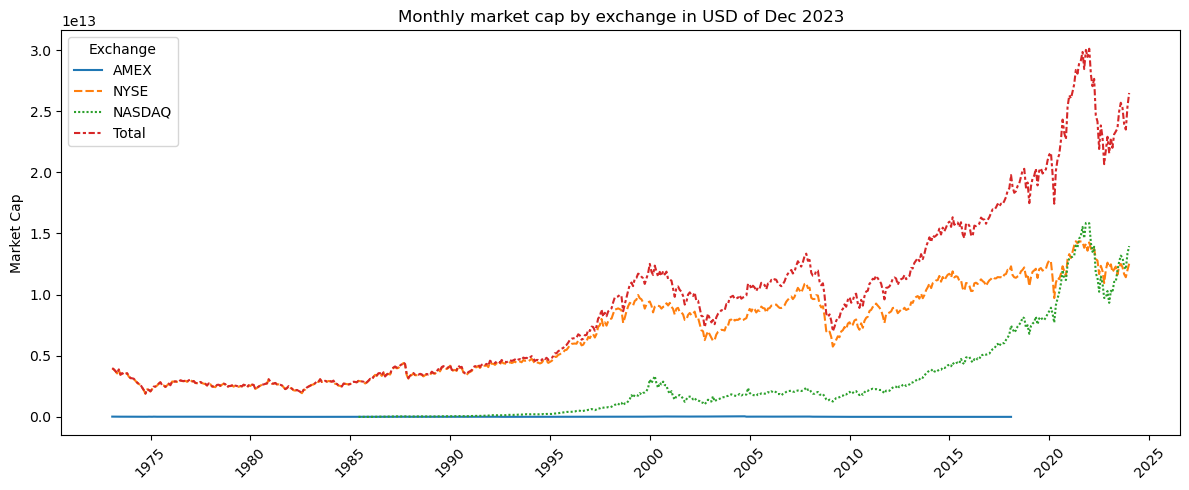

In [38]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=market_cap_per_exchange[
    market_cap_per_exchange['month'].between('1926-07-31', '2023-12-31')], 
             x="month", y="mktcap", hue="exchange", style="exchange", 
             legend='full')

# Formatting the plot
plt.xlabel("")
plt.ylabel("Market Cap")
plt.title("Monthly market cap by exchange in USD of Dec 2023")

# Set major ticks format to every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.legend(title="Exchange")
plt.tight_layout()

# Show the plot
plt.show()

This plot shows that the main exchanges in terms of market cap are by far 
NYSE and NASDAQ. Indeed, AMEX is an exchange for small caps companies. 

Now, we do the same with regard to industries.

First, we group by industry and date, then count the number of securities:

In [39]:
securities_per_industry = (crsp_m
  .groupby(["industry", "month"])
  .size()
  .reset_index(name="n")
)

Plotting with seaborn and matplotlib:

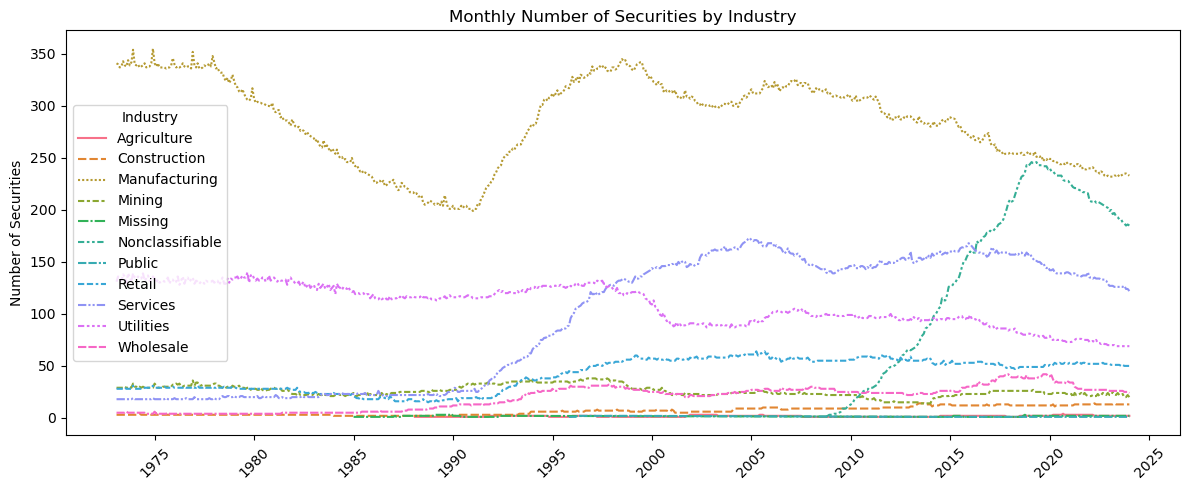

In [40]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=securities_per_industry[
    securities_per_industry['month'].between('1926-07-31', '2023-12-31')], 
             x="month", y="n", hue="industry", style="industry", legend='full')

# Formatting the plot
plt.xlabel("")
plt.ylabel("Number of Securities")
plt.title("Monthly Number of Securities by Industry")

# Set major ticks format to every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.legend(title="Industry")
plt.tight_layout()

# Show the plot
plt.show()

Now we calculates the inflation-adjusted market capitalization (market cap)
for each industry on a monthly basis. The process begins by merging the
`crsp_m` DataFrame with the `cpi_m` DataFrame using a left join on
the "month" column. This ensures that the Consumer Price Index (CPI) data is
aligned with the market cap data for each corresponding month.

The merged data is then grouped by both "month" and "industry" to calculate the
market cap for each industry within each month. The market cap is adjusted for
inflation by dividing the total market cap of the group by the average CPI for
that group. This adjustment provides a more accurate representation of market
cap by accounting for the effects of inflation over time.

The calculation is performed using the `apply` method, where a lambda function
is applied to each group. This function computes the sum of the market caps in
the group and divides it by the mean CPI for that month and industry:

In [41]:
market_cap_per_industry = (crsp_m
  .merge(cpi_m, how="left", on="month")
  .groupby(["month", "industry"])
  .apply(lambda group: pd.Series({
         "mktcap": (group["mktcap"].sum()/group["cpi"].mean())}))
  .reset_index())

market_cap_per_industry['mktcap'] = market_cap_per_industry['mktcap'].round(2)

Plotting with seaborn and matplotlib

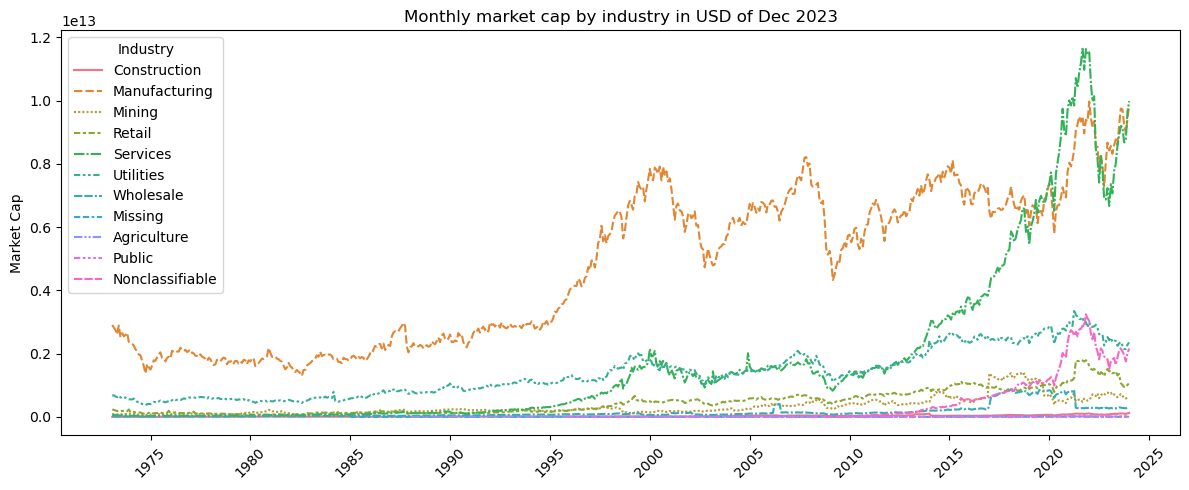

In [42]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=market_cap_per_industry[
    market_cap_per_industry['month'].between('1926-07-31', '2023-12-31')], 
             x="month", y="mktcap", hue="industry", style="industry", 
             legend='full')

# Formatting the plot
plt.xlabel("")
plt.ylabel("Market Cap")
plt.title("Monthly market cap by industry in USD of Dec 2023")

# Set major ticks format to every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.legend(title="Industry")
plt.tight_layout()

# Show the plot
plt.show()

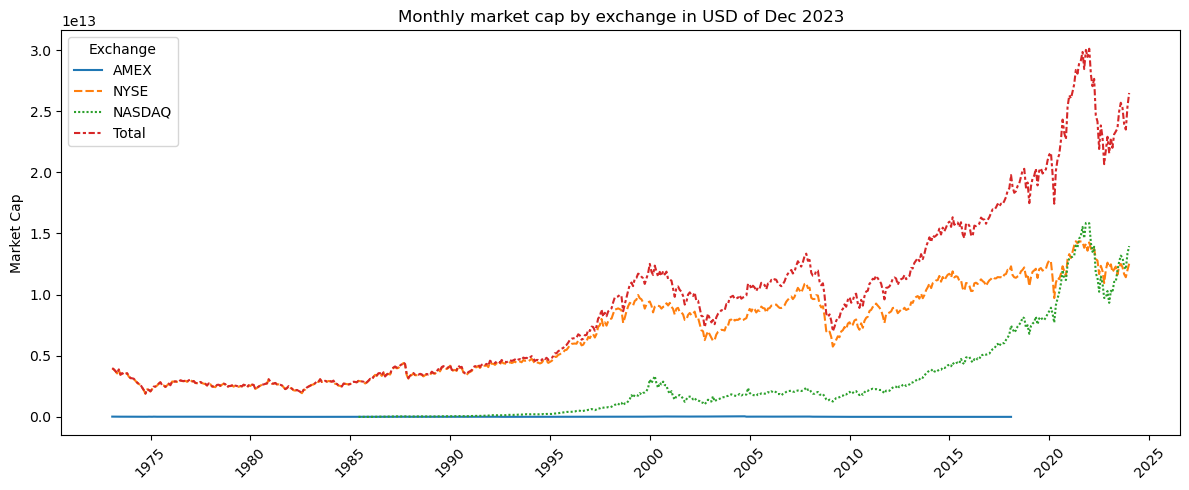

In [43]:
market_cap_per_exchange = (crsp_m
  .merge(cpi_m, how="left", on="month")
  .groupby(["month", "exchange"])
  .apply(
    lambda group: pd.Series({
      "mktcap": (group["mktcap"].sum()/group["cpi"].mean())
    })
  )
  .reset_index()
)

# Round the market cap values
market_cap_per_exchange['mktcap'] = (market_cap_per_exchange
                                              ['mktcap'].round(2))

# Calculate total market cap across all exchanges
total_market_cap = (market_cap_per_exchange
  .groupby("month")
  .agg({"mktcap": "sum"})
  .reset_index()
)

# Add a new column to identify this as the "Total" category
total_market_cap["exchange"] = "Total"

# Append the total market cap data to the original DataFrame
market_cap_per_exchange = pd.concat([market_cap_per_exchange, 
                                              total_market_cap],
                                             ignore_index=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=market_cap_per_exchange[
             market_cap_per_exchange['month'].between('1926-07-31',
                                                               '2023-12-31')],
             x="month", y="mktcap", hue="exchange", style="exchange", 
             legend='full')

# Formatting the plot
plt.xlabel("")
plt.ylabel("Market Cap")
plt.title("Monthly market cap by exchange in USD of Dec 2023")

# Set major ticks format to every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.legend(title="Exchange")
plt.tight_layout()

# Show the plot
plt.show()

**Missing Values** 

Before we treat the missing data, let's inspect how many missing data we have
in each column of the `crsp_m` dataset:

In [25]:
crsp_m.isna().sum()

permno              0
month               0
shrcd               0
exchcd              0
siccd            2144
comnam              0
dlstcd        3123154
dlret               0
prc             39864
ret             42459
shrout           3758
ret_excess      42459
mktcap          39864
exchange            0
industry            0
dtype: int64

What about the quantity of missing values for each stock? Let's inspect that:

In [12]:
# Group the dataset by 'permno' and calculate the number of missing values in
# 'ret_excess'
missing_values_by_stock = (crsp_m.groupby('permno')['ret']
                                 .apply(lambda x: x.isnull().sum())
                                 .reset_index(name='missing_values'))

# To focus only on the total number of missing values for each stock, sum 
# across columns
print(missing_values_by_stock)

      permno  missing_values
0      10006               0
1      10102               0
2      10107               1
3      10108               1
4      10137               0
...      ...             ...
1960   93423               1
1961   93426               1
1962   93428               1
1963   93429               1
1964   93436               1

[1965 rows x 2 columns]


In [13]:
missing_values_by_stock['missing_values'].mean()

0.8351145038167939

In [14]:
print(np.sort(missing_values_by_stock["missing_values"].unique()))

[ 0  1  2  3  4  5  7 15]


What about the mean, min and max of missing values through stocks?

In [15]:
print(missing_values_by_stock['missing_values'].min())

0


In [16]:
print(missing_values_by_stock['missing_values'].max())

15


How many stocks do we have registered in our database?

In [17]:
crsp_m['permno'].nunique()

1965

How many months do we have during the sample period?

In [18]:
crsp_m['month'].nunique()

612

In [19]:
# Group the dataset by 'permno' and calculate the proportion of missing values
# in 'ret_excess'
missing_values_proportion = (crsp_m.groupby('permno')['ret_excess']
                             .apply(lambda x: x.isnull().mean())
                             .reset_index(name='missing_proportion'))

cutoff = 0.10

# Filter for securities with a proportion of missing values greater than cutoff
high_missing_values = missing_values_proportion[
    missing_values_proportion['missing_proportion'] >= cutoff
]

# Count the number of securities with a high proportion of missing values
num_securities_high_missing = len(high_missing_values)

# Display the result
print(
    f"Number of securities with more than {cutoff * 100:.0f}% missing values "
    f"in 'ret_excess': {num_securities_high_missing}"
)

# Optionally, display the permno of securities with high missing values
print(high_missing_values)

Number of securities with more than 10% missing values in 'ret_excess': 0
Empty DataFrame
Columns: [permno, missing_proportion]
Index: []


In the code below, we replace by 0 the the excess return that are missing:

In [55]:
crsp_m['ret_excess'] = (crsp_m['ret_excess'].fillna(0))

# Drop rows where the 'ret_excess' column has missing values
# crsp_m = crsp_m.dropna(subset=["ret_excess"])

Notice now that we have no missing values in this column (and, except in 
`siccd`, neither in the other columns!):

In [20]:
crsp_m.isna().sum()

permno             0
month              0
shrcd              0
exchcd             0
siccd              0
comnam             0
dlstcd        380566
dlret              0
prc             1562
ret             1641
shrout           229
ret_excess         0
mktcap          1562
exchange           0
industry           0
dtype: int64

Now we save our processed dataframes to a SQLite database. The `to_sql`
method is used to write these DataFrames to the database connected via `RFFZ`.
The `if_exists="replace"` argument ensures that any existing tables with the 
same names  are replaced with the new data. The `index=False` argument prevents 
the DataFrame index from being written as a column in the database tables.


In [57]:
RFFZ = sqlite3.connect(database="data/RFFZ.sqlite")

crsp_m.to_sql(name="crsp_m", con=RFFZ, if_exists="replace", index=False)

cpi_m.to_sql(name="cpi_m", con=RFFZ, if_exists="replace", index=False)

rf_m.to_sql(name="rf_m", con=RFFZ, if_exists="replace", index=False)

RFFZ.close()

### 2.2 Global Factor Data (GFD)

In [ ]:
# Define the file path (the .csv file should be in the directory)
file_path = "[usa]_[all_factors]_[monthly]_[vw_cap].csv"

# Load the CSV file into a pandas DataFrame
global_factor_data  = pd.read_csv(file_path)

# Convert the date column to datetime
global_factor_data['date'] = pd.to_datetime(global_factor_data['date'])

In [ ]:
global_factor_data.info()

In [ ]:
global_factor_data.head()

In [ ]:
# Identify unique values for 'location', 'name', 'freq', and 'weighting'
print(global_factor_data['date'].min(), global_factor_data['date'].max(), 
      global_factor_data['name'].unique(), sep='\n')

In [ ]:
global_factor_data['name'].unique().size

In [ ]:
# Calculate descriptive statistics for the 'ret' column
descriptive_stats = global_factor_data['ret'].describe()

print(descriptive_stats)

In [ ]:
global_factor_data.groupby('name')

In [ ]:
# Specify the factor name to plot
factor_to_plot = global_factor_data['name'].unique()[10]

# Filter the data for the specified factor
factor_data = global_factor_data[global_factor_data['name'] == factor_to_plot]

# Create the plot for the specified factor
plt.figure(figsize=(10, 6))
plt.plot(factor_data['date'], factor_data['ret'], marker='o')
plt.title(f'Time Series of Returns for {factor_to_plot}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Pivot the data to have dates as index and factors as columns, 
# considering all locations
factors_pivot = global_factor_data.pivot_table(index='date', columns='name', 
                                               values='ret')

# Compute the correlation matrix for all factors
correlation_matrix_all = factors_pivot.corr()

# Identify highly positively and negatively correlated pairs
threshold_positive = 0.98
threshold_negative = -0.98

highly_pos_correlated_pairs = (correlation_matrix_all[(correlation_matrix_all >
                                                       threshold_positive) 
                               & (correlation_matrix_all != 1.0)]
                               .stack().index.tolist())
highly_neg_correlated_pairs = (correlation_matrix_all[(correlation_matrix_all <
                                                      threshold_negative)]
                               .stack().index.tolist())

# Analyze highly positively correlated pairs
print(f"Highly Positively Correlated Pairs (Threshold>{threshold_positive}):")
for pair in highly_pos_correlated_pairs:
    factor1, factor2 = pair
    correlation_value = correlation_matrix_all.at[factor1, factor2]
    print(f"{factor1} and {factor2}: {correlation_value:.4f}")

# Analyze highly negatively correlated pairs
print(f"\nHighly Negatively Correlated Pairs (Threshold<{threshold_negative}):")
for pair in highly_neg_correlated_pairs:
    factor1, factor2 = pair
    correlation_value = correlation_matrix_all.at[factor1, factor2]
    print(f"{factor1} and {factor2}: {correlation_value:.4f}")

In [ ]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
plt.imshow(correlation_matrix_all, cmap='coolwarm', interpolation='none', 
           aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix_all)), correlation_matrix_all.columns, 
           rotation=90)
plt.yticks(range(len(correlation_matrix_all)), correlation_matrix_all.columns)
plt.title('Correlation Matrix of Factors (All Locations)')

#print(correlation_matrix_all)
plt.show()

### 2.3. Open Source Asset Pricing (OSAP)

## 3. Principal Component Analysis (PCA)

We'll pivot the DataFrame so that each column represents a unique security 
(identified by `permno`) and each row corresponds to a date (`month`). The 
values in the matrix will be the monthly excess returns (`ret_excess`).

In [21]:
import prepare_missing as pm
import remove_outliers as ro
import factors_em as fem
import mrsq

In [22]:
# Pivot the DataFrame
ret_pivot = crsp_m.pivot_table(index='month', columns='permno', values='ret_excess')

# Ensure the 'month' column is formatted as 'YYYY-MM-DD' without time
ret_pivot.index = ret_pivot.index.strftime('%Y-%m-%d')

# Add the new row with transformation codes
# Create a new row called "Transform:" with 1 in every column except the first
transform_row = pd.DataFrame([[1]*len(ret_pivot.columns)], columns=ret_pivot.columns)
transform_row.index = ['Transform:']

# Insert the new row after the first row
ret_pivot = pd.concat([transform_row, ret_pivot])


In [17]:
# Save the ret_pivot DataFrame to CSV
ret_pivot.to_csv("ret_pivot.csv")

In [23]:
ret_pivot.head()

permno,10006,10102,10107,10108,10137,10145,10161,10188,10220,10225,...,93304,93312,93356,93372,93397,93423,93426,93428,93429,93436
Transform:,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1973-01-31,-0.064767,-0.168686,NaN,NaN,-0.075829,0.047324,-0.069039,-0.079872,NaN,0.034176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-28,-0.080078,-0.033160,NaN,NaN,-0.026737,0.063113,0.080453,-0.075529,NaN,-0.059094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-31,0.105829,-0.013529,NaN,NaN,-0.090314,0.065167,0.021915,-0.015589,NaN,0.004602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,-0.007962,-0.086281,NaN,NaN,0.032300,-0.024620,-0.027340,-0.072616,NaN,-0.056872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
ret_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 613 entries, Transform: to 2023-12-31
Columns: 1965 entries, 10006 to 93436
dtypes: float64(1965)
memory usage: 9.2+ MB


In [61]:
ret_pivot.isna().sum()

permno
10006    474
10102    547
10107    158
10108    378
10137    154
        ... 
93423    449
93426    450
93428    519
93429    513
93436    449
Length: 1965, dtype: int64

In [62]:
ret_pivot.isna().sum().mean()

418.37455470737916

In [63]:
ret_pivot.isna().sum().max()

560

In [64]:
ret_pivot.shape

(612, 1965)

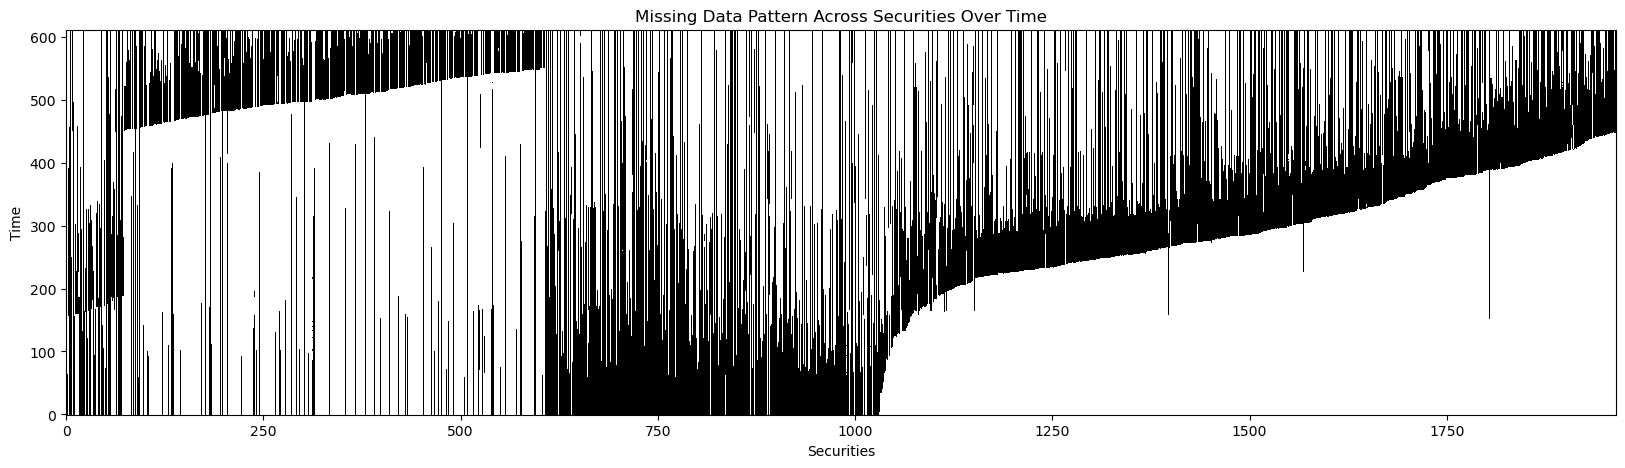

In [66]:
from matplotlib.colors import ListedColormap
# Create a binary matrix where True represents missing values and False otherwise
missing_data = ret_pivot.isnull()

custom_cmap = ListedColormap(['black', 'white'])

# Create the plot
plt.figure(figsize=(20, 5))  # Adjust the figure size for better visualization

# Use imshow to create a heatmap-like plot
plt.imshow(missing_data, aspect='auto', cmap=custom_cmap, interpolation='none')

# Set labels and title
plt.xlabel('Securities')
plt.ylabel('Time')
plt.title('Missing Data Pattern Across Securities Over Time')

# Invert y-axis so that earlier dates are at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

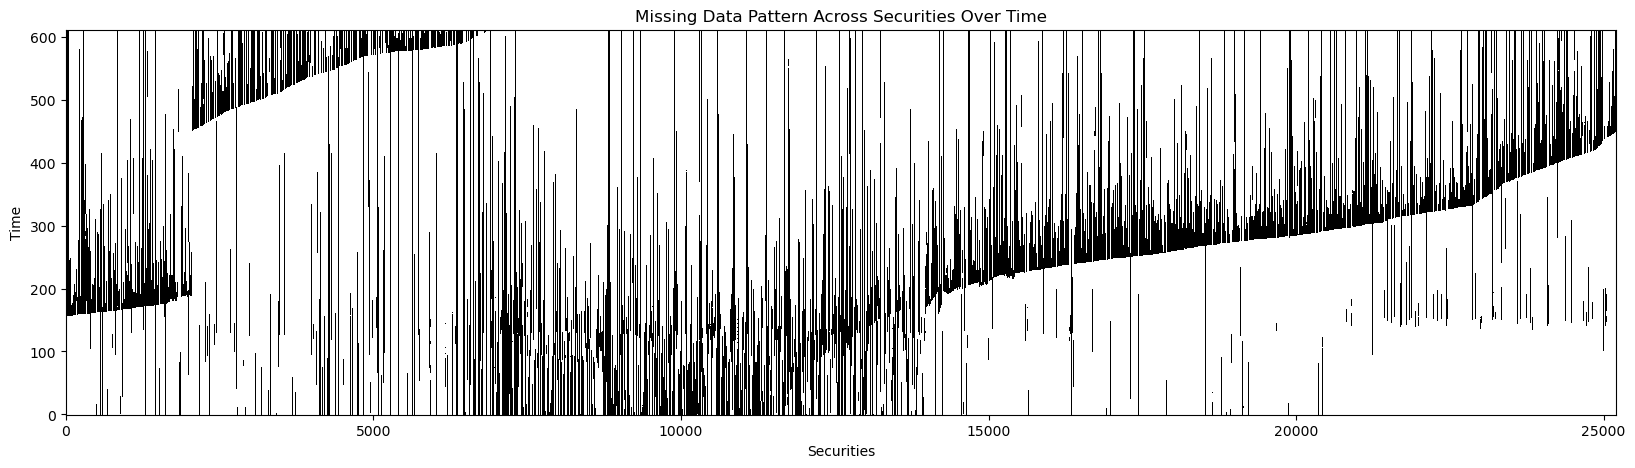

In [49]:
from matplotlib.colors import ListedColormap
# Create a binary matrix where True represents missing values and False otherwise
missing_data = ret_pivot.isnull()

custom_cmap = ListedColormap(['black', 'white'])

# Create the plot
plt.figure(figsize=(20, 5))  # Adjust the figure size for better visualization

# Use imshow to create a heatmap-like plot
plt.imshow(missing_data, aspect='auto', cmap=custom_cmap, interpolation='none')

# Set labels and title
plt.xlabel('Securities')
plt.ylabel('Time')
plt.title('Missing Data Pattern Across Securities Over Time')

# Invert y-axis so that earlier dates are at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [65]:
# Number of columns that have less than c% missing values 24335
c = ret_pivot.shape[0] * 1
len(ret_pivot.columns[ret_pivot.notna().sum() >= 10])

24520

In [66]:
# quantity of firms that have no missing values during all sample period.
ret_pivot.loc[:, ret_pivot.count() == ret_pivot.shape[0]].shape[1]

374

In [14]:
# Excluding all assets that have less than 10 observations
ret_pivot = ret_pivot.loc[:, ret_pivot.notna().sum() >= 10]

# Excluding all assets that have at least one missing value
ret_pivot_full = ret_pivot.loc[:, ret_pivot.notna().sum()==ret_pivot.shape[0]]

In [6]:
# PARAMETERS TO BE CHANGED

#csv_in = 'data/current.csv' # File name of desired FRED-MD vintage


# Type of transformation performed on each series before factors are estimated
#   0 --> no transformation
#   1 --> demean only
#   2 --> demean and standardize
#   3 --> recursively demean and then standardize

DEMEAN = 3

# Information criterion used to select number of factors; for more details,
# see auxiliary function factors_em()
#   1 --> information criterion PC_p1
#   2 --> information criterion PC_p2
#   3 --> information criterion PC_p3

jj = 2

# Maximum number of factors to be estimated; if set to 99, the number of
# factors selected is forced to equal 8
kmax = 8

# =========================================================================
# PART 1: LOAD AND LABEL DATA


dum = pd.read_csv("ret_pivot.csv").dropna(how='all')       # Load data from CSV file
dum.rename(columns={'Unnamed: 0': 'month'}, inplace=True)

series = dum.columns.values     # Variable names
tcode = dum.iloc[0, :]          # Transformation numbers
rawdata = dum.iloc[1:, :]       # Raw data
rawdata.set_index('month', inplace=True, drop=True)
rawdata.index.name = 'date'
T = len(rawdata)                # T = number of months in sample

In [ ]:
# =========================================================================
# PART 2: PROCESS DATA

# Transform raw data to be stationary using auxiliary function & prepare_missing()
yt = pm.prepare_missing(rawdata, tcode)


# Reduce sample to usable dates: remove first two months because some
# series have been first differenced
yt = yt.iloc[2:,:]

# Remove outliers using auxiliary function remove_outliers(); see function
# or readme.txt for definition of outliers
#   data = matrix of transformed series with outliers removed
#   n = number of outliers removed from each series
#data, n = ro.remove_outliers(yt)
data = yt



 # =========================================================================
 # PART 3: ESTIMATE FACTORS AND COMPUTE R-SQUARED
 #
 # Estimate factors using function factors_em()
 #   ehat    = difference between data and values of data predicted by the
 #             factors
 #   Fhat    = set of factors
 #   lamhat  = factor loadings
 #   ve2     = eigenvalues of data'*data
 #   x2      = data with missing values replaced from the EM algorithm

pred, ehat, Fhat, lamhat, ve2, x2 = fem.factors_em(data, kmax, jj, DEMEAN)


Fhat = pd.DataFrame(Fhat, index = data.index)
ehat = pd.DataFrame(ehat, index = data.index)
pred = pd.DataFrame(pred, index = data.index)

Fhat.to_excel('output/factors_py.xlsx')
ehat.to_excel('output/ehat_py.xlsx')
pred.to_excel('output/pred_py.xlsx')

#  Compute R-squared and marginal R-squared from estimated factors and
#  factor loadings using function mrsq()
#    R2      = R-squared for each series for each factor
#    mR2     = marginal R-squared for each series for each factor
#    mR2_F   = marginal R-squared for each factor
#    R2_T    = total variation explained by all factors
#    t10_s   = top 10 series that load most heavily on each factor
#    t10_mR2 = marginal R-squared corresponding to top 10 series
#              that load most heavily on each factor
#
#
R2, mR2, mR2_F, R2_T, t10_s, t10_mR2 = mrsq.mrsq(Fhat,lamhat,ve2,data.columns.values)

print('R2', pd.DataFrame(R2).to_string())
print('mR2', pd.DataFrame(mR2).to_string())
print('mR2_F', mR2_F)
print('R2_T', R2_T)
print('t10_s', pd.DataFrame(t10_s).to_string())
print('t10_mR2', pd.DataFrame(t10_mR2).to_string())

## Last edit: 2024-09-16 15:53.